# Prepare DepMap data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import janitor
from pathlib import Path
import re

In [2]:
data_dir = Path('../data')
save_dir = Path('../modeling_data')

## 'sample_info.csv'

In [3]:
sample_info_columns = [
    'depmap_id', 'stripped_cell_line_name', 'ccle_name', 'sex', 
    'cas9_activity', 'primary_or_metastasis', 'primary_disease',
    'subtype', 'lineage', 'lineage_subtype',
]

sample_info = pd.read_csv(data_dir / 'sample_info.csv') \
    .clean_names() \
    [sample_info_columns]
sample_info.head()

,depmap_id,stripped_cell_line_name,ccle_name,sex,cas9_activity,primary_or_metastasis,primary_disease,subtype,lineage,lineage_subtype
0,ACH-000001,NIHOVCAR3,NIHOVCAR3_OVARY,Female,NaN,Metastasis,Ovarian Cancer,"Adenocarcinoma, high grade serous",ovary,ovary_adenocarcinoma
1,ACH-000002,HL60,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,Female,NaN,Primary,Leukemia,"Acute Myelogenous Leukemia (AML), M3 (Promyelo...",blood,AML
2,ACH-000003,CACO2,CACO2_LARGE_INTESTINE,Male,NaN,NaN,Colon/Colorectal Cancer,Adenocarcinoma,colorectal,colorectal_adenocarcinoma
3,ACH-000004,HEL,HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,Male,47.6,NaN,Leukemia,"Acute Myelogenous Leukemia (AML), M6 (Erythrol...",blood,AML
4,ACH-000005,HEL9217,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,Male,13.4,NaN,Leukemia,"Acute Myelogenous Leukemia (AML), M6 (Erythrol...",blood,AML


In [4]:
sample_info.to_csv(save_dir / 'sample_info.csv', index=False)

## 'Achilles_guide_map.csv'

In [5]:
achilles_guide_map = pd.read_csv(data_dir / 'Achilles_guide_map.csv') \
    .clean_names() \
    .assign(hugo_symbol=lambda x: [a.split(' ')[0] for a in x.gene]) \
    .drop(['gene'], axis=1)

achilles_guide_map.head()

,sgrna,genome_alignment,n_alignments,hugo_symbol
0,AAAAAAATCCAGCAATGCAG,chr10_110964620_+,1,SHOC2
1,AAAAAACCCGTAGATAGCCT,chr12_95003615_+,1,NDUFA12
2,AAAAAAGAAGAAAAAACCAG,chr4_75970356_-,1,SDAD1
3,AAAAAAGCTCAAGAAGGAGG,chr2_33588446_-,1,FAM98A
4,AAAAAAGGCTGTAAAAGCGT,chr19_19891600_+,1,ZNF253


## 'Achilles_dropped_guides.csv'

In [6]:
achilles_dropped_guides = pd.read_csv(data_dir / 'Achilles_dropped_guides.csv') \
    .clean_names() \
    .rename({'unnamed_0': 'sgrna'}, axis=1)

achilles_dropped_guides.head()

,sgrna,genomic_coordinates,gene,n_alignments,fail_reason
0,AAAAAGCTTCCGCCTGATGG,NaN,NaN,0.0,not_aligned
1,AAAAATCCTAAAATAAAATA,chrX_145827835.0_-,NaN,1.0,in_dropped_guides
2,AAAACAGAATATAGTCAGTG,chrX_145827787.0_-,NaN,1.0,guide_dropped_by_ceres
3,AAAACAGGACGATGTGCGGC,NaN,NaN,0.0,not_aligned
4,AAAACATCGACCGAAAGCGT,NaN,NaN,0.0,not_aligned


In [7]:
len(np.unique(achilles_dropped_guides.sgrna))

2554

In [8]:
achilles_guide_map = achilles_guide_map[~achilles_guide_map.sgrna.isin(achilles_dropped_guides.sgrna)]
achilles_guide_map = achilles_guide_map.reset_index(drop=True)

In [9]:
achilles_guide_map.to_csv(save_dir / 'achilles_guide_map.csv', index=False)

## 'Achilles_replicate_map.csv'

In [10]:
achilles_replicate_map = pd.read_csv(data_dir / 'Achilles_replicate_map.csv') \
    .clean_names() \
    .assign(replicate_id=lambda x: x.replicate_id.str.lower())
achilles_replicate_map.head()

,replicate_id,depmap_id,pdna_batch,passes_qc
0,pacadd188-311cas9_repb_p6_batch3,ACH-001382,3,True
1,kmrc20-311cas9_repa_p6_batch3,ACH-000250,3,True
2,253j-311cas9_repa_p5_batch3,ACH-000011,3,True
3,ocug1-311cas9-repb-p6_batch3,ACH-001619,3,True
4,raji-311cas9_repb_p6_batch3,ACH-000654,3,True


In [11]:
np.max(achilles_replicate_map.pdna_batch)

4

In [12]:
len(np.unique(achilles_replicate_map.replicate_id))

1638

In [13]:
np.round(np.mean(achilles_replicate_map.passes_qc), 3)

0.996

In [14]:
achilles_replicate_map.to_csv(save_dir / 'achilles_replicate_map.csv', index=False)

## 'Achilles_logfold_change.csv'

In [15]:
achilles_logfold_change = pd.read_csv(data_dir / 'Achilles_logfold_change.csv') \
    .rename({'Construct Barcode': 'sgrna'}, axis=1) \
    .set_index('sgrna') \
    .melt(var_name='replicate_id', value_name='lfc', ignore_index=False) \
    .reset_index() \
    .assign(replicate_id=lambda x: x.replicate_id.str.lower()) \
    .merge(achilles_replicate_map, on='replicate_id', how='left') \
    .pipe(lambda x: x[x.passes_qc])

achilles_logfold_change.head()

,sgrna,replicate_id,lfc,depmap_id,pdna_batch,passes_qc
0,AAAAAAATCCAGCAATGCAG,143b-311cas9_repa_p6_batch3,0.289694,ACH-001001,3,True
1,AAAAAACCCGTAGATAGCCT,143b-311cas9_repa_p6_batch3,0.170172,ACH-001001,3,True
2,AAAAAAGAAGAAAAAACCAG,143b-311cas9_repa_p6_batch3,-0.695947,ACH-001001,3,True
3,AAAAAAGCTCAAGAAGGAGG,143b-311cas9_repa_p6_batch3,-0.324935,ACH-001001,3,True
4,AAAAAAGGCTGTAAAAGCGT,143b-311cas9_repa_p6_batch3,0.142874,ACH-001001,3,True


In [16]:
if achilles_logfold_change.depmap_id.isnull().values.any():
    raise Exception('Some data points are missing cell line assignments.')

In [17]:
if not np.all(achilles_logfold_change.passes_qc):
    raise Exception('Some data does not pass QC.')

In [18]:
achilles_logfold_change.shape

(121067627, 6)

In [19]:
achilles_logfold_change.to_csv(save_dir / 'achilles_logfold_change.csv', 
                               index=False)

## 'CCLE_mutations.csv'

In [20]:
ccle_mutations_columns = [
    'depmap_id', 
    'hugo_symbol', 'chromosome', 'start_position', 'end_position',
    'variant_classification', 'variant_type', 'reference_allele', 
    'tumor_seq_allele1', 'cdna_change', 'codon_change', 'protein_change',
    'isdeleterious', 'istcgahotspot', 'iscosmichotspot'
]

ccle_mutations = pd.read_csv(data_dir / 'CCLE_mutations.csv', 
                             delimiter='\t', low_memory=False) \
    .clean_names() \
    [ccle_mutations_columns]

ccle_mutations.head()

,depmap_id,hugo_symbol,chromosome,start_position,end_position,variant_classification,variant_type,reference_allele,tumor_seq_allele1,cdna_change,codon_change,protein_change,isdeleterious,istcgahotspot,iscosmichotspot
0,ACH-000986,A1BG,19,58858743,58858743,Missense_Mutation,SNP,C,T,c.1456G>A,c.(1456-1458)Gac>Aac,p.D486N,False,False,False
1,ACH-000988,A1BG,19,58858810,58858810,Silent,SNP,C,T,c.1389G>A,c.(1387-1389)caG>caA,p.Q463Q,False,False,False
2,ACH-002182,A1BG,19,58858867,58858867,Missense_Mutation,SNP,C,G,c.1332G>C,c.(1330-1332)aaG>aaC,p.K444N,False,False,False
3,ACH-000985,A1BG,19,58858872,58858872,Missense_Mutation,SNP,C,T,c.1327G>A,c.(1327-1329)Gtg>Atg,p.V443M,False,False,False
4,ACH-001793,A1BG,19,58858914,58858914,Missense_Mutation,SNP,C,T,c.1285G>A,c.(1285-1287)Gac>Aac,p.D429N,False,False,False


In [21]:
ccle_mutations.to_csv(save_dir / 'ccle_mutations.csv', index=False)

### *KRAS* mutations

In [22]:
kras_mutations_columns = [
    'depmap_id', 'start_position', 'end_position', 
    'variant_classification', 'variant_type', 'protein_change',
    'isdeleterious', 'istcgahotspot', 'iscosmichotspot'
]

kras_hotspot_codons = ['12', '13', '61', '146']

kras_mutations = ccle_mutations[ccle_mutations.hugo_symbol == 'KRAS'] \
    [kras_mutations_columns] \
    .assign(
        variant_classification=lambda x: x.variant_classification.str.lower(),
        variant_type=lambda x: x.variant_type.str.lower(),
        codon=lambda x: [re.sub('\D', '', a) for a in x.protein_change],
        is_kras_hotspot=lambda x: x.codon.isin(kras_hotspot_codons)
    ) \
    .pipe(lambda x: x[x.variant_classification != 'silent']) \
    .pipe(lambda x: x[x.is_kras_hotspot | x.iscosmichotspot | x.istcgahotspot | x.isdeleterious]) \
    .assign(kras_allele=lambda x: [a if b else "other" for a,b in zip(x.protein_change, x.is_kras_hotspot)]) \
    .assign(kras_allele=lambda x: [re.sub('p.', '', a) for a in x.kras_allele]) \
    .drop_duplicates() \
    .reset_index(drop=True)


kras_mutations.head()

,depmap_id,start_position,end_position,variant_classification,variant_type,protein_change,isdeleterious,istcgahotspot,iscosmichotspot,codon,is_kras_hotspot,kras_allele
0,ACH-000981,25368390,25368390,frame_shift_del,del,p.K185fs,True,False,False,185,False,other
1,ACH-001650,25368390,25368390,frame_shift_del,del,p.K185fs,True,False,False,185,False,other
2,ACH-002238,25368390,25368390,frame_shift_del,del,p.K185fs,True,False,False,185,False,other
3,ACH-000996,25368455,25368455,nonsense_mutation,snp,p.R164*,True,False,False,164,False,other
4,ACH-000218,25378561,25378561,missense_mutation,snp,p.A146V,False,True,True,146,True,A146V


In [23]:
kras_mutations[['kras_allele', 'depmap_id']] \
    .groupby('kras_allele') \
    .count() \
    .sort_values('depmap_id', ascending=False)

,depmap_id
kras_allele,
G12D,68
G12V,47
G12C,27
other,18
G12A,16
G13D,14
Q61H,9
G12S,8
G12R,8


In [24]:
kras_mutations.to_csv(save_dir / 'kras_mutations.csv', index=False)

In [25]:
mult_kras_mutations = kras_mutations[['depmap_id', 'kras_allele']] \
    .groupby('depmap_id') \
    .count() \
    .pipe(lambda x: x[x.kras_allele > 1]) \
    .sort_values('kras_allele', ascending=False) \
    .reset_index(drop=False)

mult_kras_mutations

,depmap_id,kras_allele
0,ACH-000718,3
1,ACH-000249,2
2,ACH-000264,2
3,ACH-000314,2
4,ACH-000344,2
5,ACH-001001,2
6,ACH-001094,2
7,ACH-001378,2
8,ACH-001650,2
9,ACH-001857,2


In [26]:
kras_mult_mutations_fix = kras_mutations[kras_mutations.depmap_id.isin(mult_kras_mutations.depmap_id)] \
    .reset_index(drop=True) \
    .pipe(lambda x: x[x.is_kras_hotspot]) \
    .sort_values('depmap_id')

kras_mult_mutations_fix

,depmap_id,start_position,end_position,variant_classification,variant_type,protein_change,isdeleterious,istcgahotspot,iscosmichotspot,codon,is_kras_hotspot,kras_allele
1,ACH-000249,25380275,25380275,missense_mutation,snp,p.Q61H,False,True,True,61,True,Q61H
3,ACH-000264,25380277,25380277,missense_mutation,snp,p.Q61K,False,True,True,61,True,Q61K
6,ACH-000264,25380277,25380278,missense_mutation,dnp,p.Q61K,False,True,True,61,True,Q61K
2,ACH-000314,25380275,25380275,missense_mutation,snp,p.Q61H,False,True,True,61,True,Q61H
10,ACH-000314,25398282,25398282,missense_mutation,snp,p.G13C,False,True,True,13,True,G13C
4,ACH-000344,25380277,25380277,missense_mutation,snp,p.Q61K,False,True,True,61,True,Q61K
5,ACH-000344,25380277,25380278,missense_mutation,dnp,p.Q61K,False,True,True,61,True,Q61K
11,ACH-000718,25398284,25398284,missense_mutation,snp,p.G12V,False,True,True,12,True,G12V
16,ACH-000718,25398285,25398285,missense_mutation,snp,p.G12C,False,True,True,12,True,G12C
15,ACH-000718,25398284,25398285,missense_mutation,dnp,p.G12F,False,True,True,12,True,G12F


In [27]:
kras_mut_blacklist = [
    'ACH-000718'
]

kras_mult_mutations_fix[['depmap_id', 'kras_allele']] \
    .pipe(lambda x: x[~x.depmap_id.isin(kras_mut_blacklist)]) \
    .groupby('depmap_id') \
    .count() \
    .sort_values('kras_allele', ascending=False) \
    .reset_index(drop=False)

,depmap_id,kras_allele
0,ACH-000264,2
1,ACH-000314,2
2,ACH-000344,2
3,ACH-001378,2
4,ACH-001857,2
5,ACH-000249,1
6,ACH-001001,1
7,ACH-001094,1
8,ACH-001650,1


## 'CCLE_segment_cn.csv'

In [60]:
ccle_segment_cn = pd.read_csv(data_dir / 'CCLE_segment_cn.csv') \
    .clean_names()
ccle_segment_cn.head()

,depmap_id,chromosome,start,end,num_probes,segment_mean,source
0,ACH-000001,1,1,1969745,286,2.546065,Sanger WES
1,ACH-000001,1,1969746,6354345,365,2.175759,Sanger WES
2,ACH-000001,1,6354346,6958256,100,3.109430,Sanger WES
3,ACH-000001,1,6958257,15977206,884,2.134831,Sanger WES
4,ACH-000001,1,15977207,16174774,57,2.952592,Sanger WES


In [61]:
ccle_segment_cn.to_csv(save_dir / 'ccle_semgent_cn.csv', index=False)

## 'CCLE_gene_cn.csv'

In [62]:
ccle_gene_cn = pd.read_csv(data_dir / 'CCLE_gene_cn.csv') \
    .rename({'Unnamed: 0': 'depmap_id'}, axis=1) \
    .melt(id_vars='depmap_id', var_name='hugo_symbol', value_name='log2_cn_p1') \
    .assign(hugo_symbol=lambda x: [a.split(' ')[0] for a in x.hugo_symbol],
            cn=lambda x: np.exp(x.log2_cn_p1) - 1)

ccle_gene_cn.head()

,depmap_id,hugo_symbol,log2_cn_p1,cn
0,ACH-000001,A1BG,1.179621,2.253141
1,ACH-000002,A1BG,1.009801,1.745055
2,ACH-000003,A1BG,1.022828,1.781048
3,ACH-000004,A1BG,1.232225,2.428849
4,ACH-000005,A1BG,1.151880,2.164136


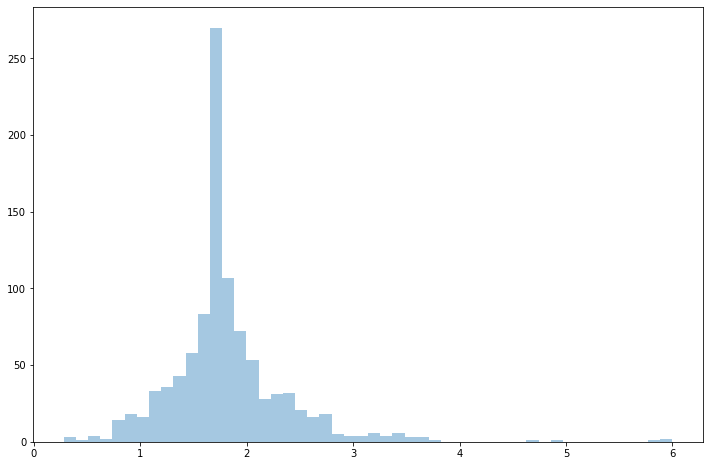

In [64]:
fig = plt.figure(figsize=(12, 8))
x = [np.min([a, 6]) for a in ccle_gene_cn.cn.sample(n=1000)]
sns.distplot(x, kde=False)
plt.show()

## 'CCLE_fusions.csv'

In [72]:
ccle_fusions = pd.read_csv(data_dir / 'CCLE_fusions.csv', delimiter='\t') \
    .clean_names() \
    .rename({'#fusionname': 'fusion_name',
             'junctionreadcount': 'junction_read_count',
             'spanningfragcount': 'spanning_frag_count',
             'splicetype': 'splice_type',
             'leftgene': 'left_gene',
            'leftbreakpoint': 'left_break_point',
            'rightgene': 'right_gene',
            'rightbreakpoint': 'right_break_point',
            'largeanchorsupport': 'large_anchor_support',
            'leftbreakdinuc': 'left_break_dinuc',
            'leftbreakentropy': 'left_break_entropy',
            'rightbreakdinuc': 'right_break_dinuc',
            'rightbreakentropy': 'right_break_entropy'},
            axis=1)
ccle_fusions.head()

,depmap_id,fusion_name,junction_read_count,spanning_frag_count,splice_type,left_gene,left_break_point,right_gene,right_break_point,large_anchor_support,ffpm,left_break_dinuc,left_break_entropy,right_break_dinuc,right_break_entropy,annots,ccle_count
0,ACH-001113,CACNA2D1--SEMA3E,48,53,ONLY_REF_SPLICE,CACNA2D1 (ENSG00000153956),chr7:82335135:-,SEMA3E (ENSG00000170381),chr7:83469302:-,YES_LDAS,1.5703,GT,1.9899,AG,1.9899,"[""CCLE_StarF2019"",""INTRACHROMOSOMAL[chr7:0.92M...",2
1,ACH-001113,ADNP2--PLIN3,50,40,INCL_NON_REF_SPLICE,ADNP2 (ENSG00000101544),chr18:80117650:+,PLIN3 (ENSG00000105355),chr19:4867657:-,YES_LDAS,1.3993,GT,1.7819,AG,1.8323,"[""CCLE_StarF2019"",""INTERCHROMOSOMAL[chr18--chr...",2
2,ACH-001113,XRCC4--SUGCT,23,104,ONLY_REF_SPLICE,XRCC4 (ENSG00000152422),chr5:83111203:+,SUGCT (ENSG00000175600),chr7:40749434:+,YES_LDAS,1.9745,GT,1.9656,AG,1.9656,"[""CCLE_StarF2019"",""INTERCHROMOSOMAL[chr5--chr7]""]",2
3,ACH-001113,PCYT1A--RBFOX1,26,48,ONLY_REF_SPLICE,PCYT1A (ENSG00000161217),chr3:196247367:-,RBFOX1 (ENSG00000078328),chr16:6654603:+,YES_LDAS,1.1505,GT,1.7819,AG,1.8295,"[""CCLE_StarF2019"",""INTERCHROMOSOMAL[chr3--chr1...",4
4,ACH-001113,AF117829.1--PIP4P2,25,31,ONLY_REF_SPLICE,AF117829.1 (ENSG00000251136),chr8:89757045:-,PIP4P2 (ENSG00000155099),chr8:90996744:-,YES_LDAS,0.8707,GT,1.8062,AG,1.9329,"[""INTRACHROMOSOMAL[chr8:1.24Mb]""]",2


In [73]:
ccle_fusions.to_csv(save_dir / 'ccle_fusions.csv', index=False)

## 'CCLE_expression_full_v2.csv'

In [74]:
pd.read_csv(data_dir / 'CCLE_expression_full_v2.csv', nrows=10)

,Unnamed: 0,TSPAN6 (ENSG00000000003),TNMD (ENSG00000000005),DPM1 (ENSG00000000419),SCYL3 (ENSG00000000457),C1orf112 (ENSG00000000460),FGR (ENSG00000000938),CFH (ENSG00000000971),FUCA2 (ENSG00000001036),GCLC (ENSG00000001084),...,AC136297.1 (ENSG00000285985),BX248415.1 (ENSG00000285986),AL157886.1 (ENSG00000285987),AL392086.3 (ENSG00000285988),AL357123.1 (ENSG00000285989),AL589743.7 (ENSG00000285990),AL355312.5 (ENSG00000285991),AC120036.5 (ENSG00000285992),AC018931.1 (ENSG00000285993),AL731559.1 (ENSG00000285994)
0,ACH-001097,0.000000,0.0,4.667324,1.761285,3.554589,4.358959,0.641546,2.201634,1.941106,...,0.0,0.0,0.056584,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
1,ACH-001636,0.000000,0.0,6.198887,2.032101,3.755956,2.601697,0.000000,0.000000,3.415488,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.111031,0.0,0.0,0.0
2,ACH-001804,4.934988,0.0,6.635464,1.929791,2.503349,0.000000,4.883621,6.772546,3.889474,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.298658,0.0,0.0,0.0
3,ACH-000534,0.839960,0.0,5.376082,2.687061,4.440288,4.938286,0.536053,3.584963,2.935460,...,0.0,0.0,0.000000,0.028569,0.0,1.084064,0.000000,0.0,0.0,0.0
4,ACH-001498,1.744161,0.0,6.846744,2.147307,3.666757,5.252098,0.014355,1.641546,4.100978,...,0.0,0.0,0.000000,0.000000,0.0,0.111031,0.000000,0.0,0.0,0.0
5,ACH-000742,3.722466,0.0,6.029674,2.192194,2.533563,0.150560,5.933809,6.973382,5.192194,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.604071,0.0,0.0,0.0
6,ACH-002018,5.121015,0.0,5.989139,1.863938,4.035624,0.028569,0.056584,5.948601,4.627607,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.097611,0.0,0.0,0.0
7,ACH-000836,4.632268,0.0,6.704180,2.792855,4.079805,0.097611,1.150560,5.729553,4.802193,...,0.0,0.0,0.000000,0.000000,0.0,0.871844,0.000000,0.0,0.0,0.0
8,ACH-000545,4.251719,0.0,5.651052,3.440952,3.275007,1.541019,6.659496,6.478648,5.566206,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
9,ACH-001617,0.000000,0.0,6.916357,2.722466,4.120186,0.432959,0.000000,0.056584,4.426936,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.056584,0.0,0.0,0.0
